# HW10, Assignment 2 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

Author: Sina Kashuk  
Modified for HW by Bailey Griswold, bg1672  
November 23, 2016

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [120]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [3]:
from __future__ import print_function
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import statsmodels.api as sm
import shapely
import pysal as ps
import seaborn as sns
from matplotlib import colors

## Working with Shape File

### Loading Census Tract Shape File¶

In [4]:
shape_path = "ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010 
#set the index is set to the boro census tract

### Coordinate systems, projections, and transformations 

In [5]:
ct_shape.crs = from_epsg(4326) 
#epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
#NAD planer coordinates of 1983
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) 
# from ft2 to mi2 
print ('total NYC land area: %s (mi^2)'%str(NYC_Area)[:5])
# from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

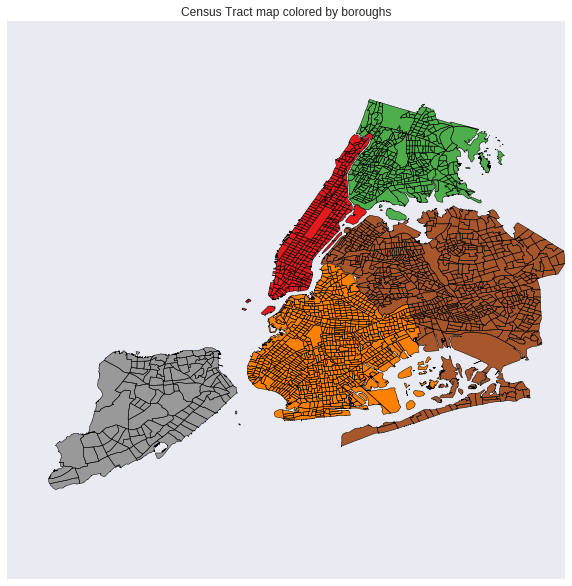

In [6]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode', alpha=1, linewidth=0.5, ax=ax) 
#colors it based on the borough
plt.title("Census Tract map colored by boroughs")

*** Figure 1: Census Tracts of New York City Colored according to Borough ***

### Map NYC Population density

#### Load Census Data for 2010

In [7]:
ct_data = DataFrame.from_csv('ACS_CT2010.csv')
#set index to be the BoroCT2010 code, to be explicit
#since indeces of both data sets are boro census tract, then you can link them
ct_data.index = ct_data.BoroCT2010.astype(str)
#data set from socialexplorer

#### Add popuation density to CT shapefile

In [8]:
ct_shape_pop = ct_shape.join(ct_data[['SE_T002_002']]) 
#SE_T002_002 is population density in social explorer dataset
#linked by the indeces (boro census tract), which explicitly set for both data sets

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


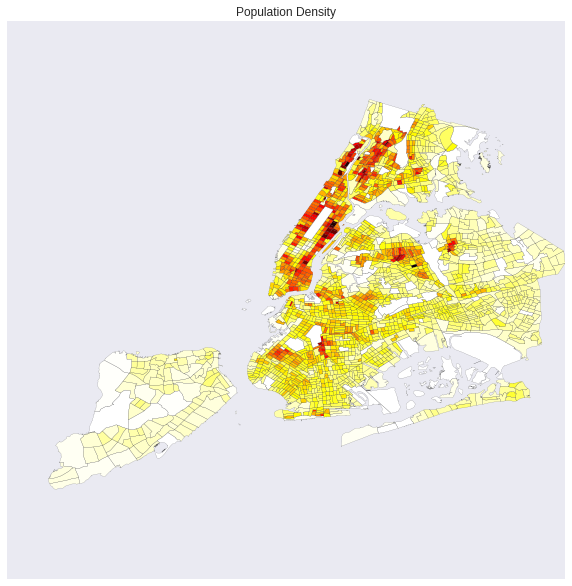

In [9]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002', colormap='hot_r', alpha=1, linewidth=0.1, ax=ax)
plt.title("Population Density")
plt.legend(fontsize = 15, loc = 'best')

*** Figure 2: Population Density of NYC, 2010 census data. ***
Manhattan, South Bronx, central Brooklyn and central Queens have the most dense populations.  

## Explore CitiBike data

### Load CitiBike data

In [10]:
df_bike_monthly = DataFrame.from_csv('CitiBike_monthly_byStation.csv')
df_bike_monthly.head()
# columns are stations
# rows are time

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

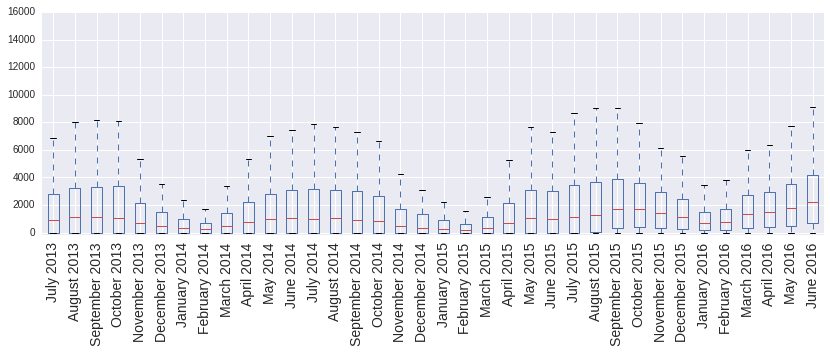

In [11]:
plt.rcParams['font.size'] = 14
f, ax = plt.subplots(figsize = (14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_ = df_bike_monthly.copy()
df_bike_monthly_.index = df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize = (15,7), ax = ax, rot = 90);
ax.set_ylim([-200,16000])
#use t to transpose so you get time on x, and dation on y axis

*** Figure 3: Monthly Quartiles for Citibike Rides from July 2013 to June 2016 ***
There is a clear periodicity in the data with peak ridership rising through the summer months, and decreasing to a minimum in January and February.  

#### Seasonal Decomposition

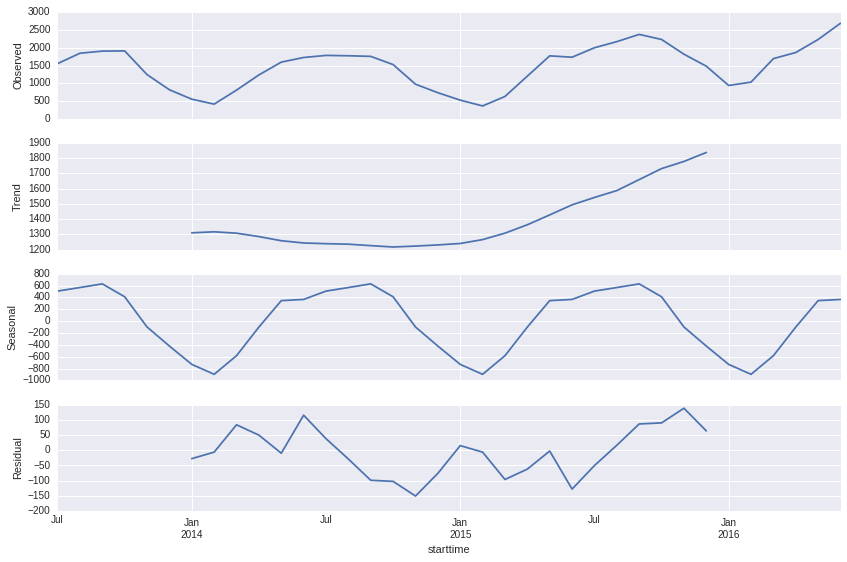

In [13]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new = df_bike_monthly.mean(1).resample('M').mean() 
#meaned monthly values across stattions
df_new.interpolate(inplace = True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

*** Figure 4 Seasonal Decomposition of Citibike Data (June 2013 - June 2016) ***
The maximum seasonal value is high (800) compared to maximum residual value (150), suggesting a high seasonality.  There is also an overall trend of ridership increasing over time, as indiciated by the decomposition.

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [14]:
station_id = DataFrame.from_csv('Station_id.csv')
#convert station_ids to string index
station_id.index = station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [15]:
# combine lat and lon to one column
station_id['lonlat'] = zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']]\
    .applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [16]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)]\
             .BoroCT2010.values[0])
    #print ('\r',"%",str((i+1)*100./len(station_id))[:4],)
station_id['BoroCT2010']=a
# backslash r, removes line to create a running percentage

In [17]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [23]:
winter = (df_bike_monthly.index.month <= 3) | (df_bike_monthly.index.month == 12)
summer = (df_bike_monthly.index.month <= 9) & (df_bike_monthly.index.month >= 6)

df_winter = df_bike_monthly[winter]
df_summer = df_bike_monthly[summer]

df_winter[df_winter == 0] = np.nan
df_summer[df_summer == 0] = np.nan

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
print (df_winter.head())
print (df_summer.head())

            1000    1001  1002  1003  1004  1005  1006  1007    1008  1009  \
starttime                                                                    
2013-12-31  1299  1650.0  4081  1686  3046  1575   830  1890  2048.0  1009   
2014-01-31   956  1337.0  3178  1251  1920  1130   477  1412  1082.0   681   
2014-02-28   650   960.0  2920   676  1808   933   508  1045   963.0   530   
2014-03-31   804  1559.0  5102  1441  2643  1477   849  2004  2105.0   880   
2014-12-31  1052  1304.0  4501  1783  2985  2091   779  2108  1636.0   878   

            ...   1533  1534  1535  1536  1537  1538  1539  1540  1541  1542  
starttime   ...                                                               
2013-12-31  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2014-01-31  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2014-02-28  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2014-03-31  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN

In [25]:
station_id['WinterAve']=df_winter.mean(skipna = True)
station_id['SummerAve']=df_summer.mean(skipna = True)

In [34]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,WinterAve,SummerAve,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,1096.916667,2558.000000,1925.222222
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,1790.333333,4178.727273,2856.222222
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,4411.666667,9903.083333,7597.916667
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,1628.416667,3732.833333,2831.916667
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,2609.916667,6895.750000,5112.333333


In [27]:
### Create average monthly rides column from monthly citibike data 
#and add it to the station id which has the geometry
station_id['MonthlyAve']=df_bike_monthly.mean(skipna = True)
# all the value were time, so sum them all, so that you have only one value per station
#need to change this line for hw to make a summer and a winter

In [28]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,WinterAve,SummerAve,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,1096.916667,2558.000000,1925.222222
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,1790.333333,4178.727273,2856.222222
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,4411.666667,9903.083333,7597.916667
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,1628.416667,3732.833333,2831.916667
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,2609.916667,6895.750000,5112.333333


### Add the monthly average rides to the CT shapefile 

In [29]:
temp = station_id[['WinterAve']]
temp['station_id'] = station_id.index
temp.index = station_id['BoroCT2010']
#set the index of this new temp dataframe, since shape file index is boroct
ct_shape_WinterAve = ct_shape.join(temp)
#join the temp dataframe to the shape file
ct_shape_WinterAve.fillna(0,inplace=True)

temp2 = station_id[['SummerAve']]
temp2['station_id'] = station_id.index
temp2.index = station_id['BoroCT2010']
#set the index of this new temp dataframe, since shape file index is boroct
ct_shape_SummerAve = ct_shape.join(temp2)
#join the temp dataframe to the shape file
ct_shape_SummerAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


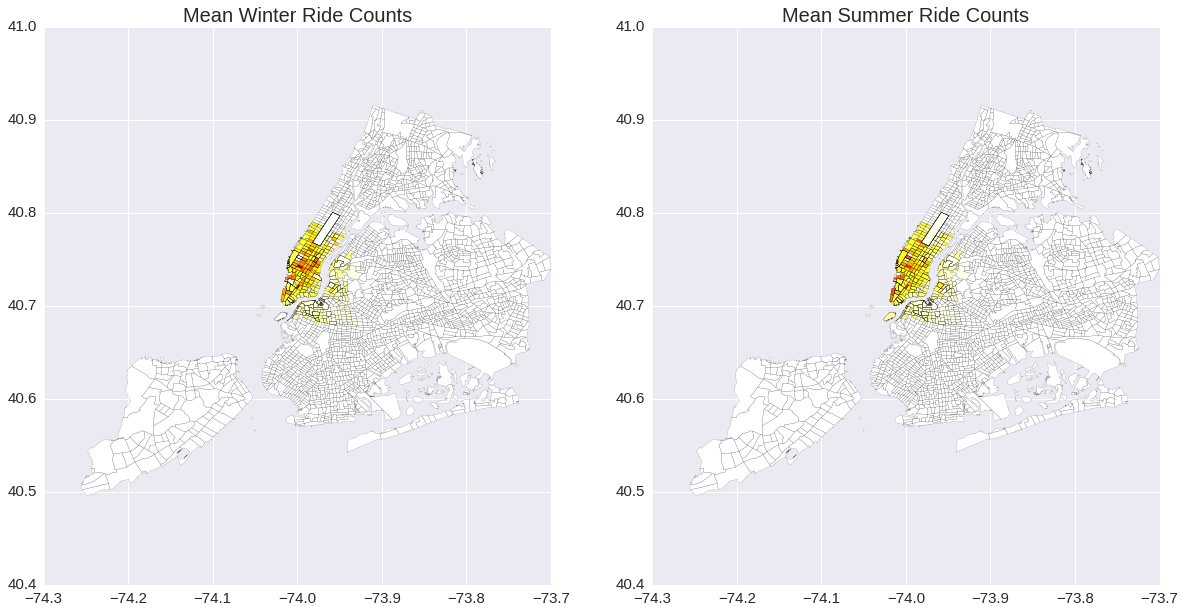

In [33]:
f, ax = plt.subplots(figsize=(20,10))

ax1 = plt.subplot(121)
ct_shape_WinterAve.plot(column = 'WinterAve', colormap = 'hot_r',\
                        alpha = 1, linewidth = 0.1, ax = ax1)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Mean Winter Ride Counts", fontsize = 20)

ax2 = plt.subplot(122)
ct_shape_SummerAve.plot(column = 'SummerAve', colormap = 'hot_r',
                        alpha = 1, linewidth = 0.1, ax = ax2)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Mean Summer Ride Counts", fontsize = 20)

*** Figure 5: Relative Citibike Ridership Means by Census Tract in Winter (left) and Summer (right)*** The mean number of monthly rides (June 2013 - June 2016) per citibike station in winter and summer are plotted according to the census tract they are located in.  Citibike data is concentrated downtond and midtown Manhattan as well as downtown Brooklyn, because those are the only neighrborhoods that have citibike stations.  

### Removing the CTs that are out of zoom boundries

In [35]:
ct_shape_WinterAve_Zoom = (ct_shape_WinterAve[ct_shape_WinterAve
                           .centroid
                           .apply(lambda c:c.x >- 74.1 and c.x <- 73.92 \
                                  and c.y > 40.65 and c.y < 40.8)])
#centroid, give it a boundary, the lat and long are the boundaries
#everything beyond it is false, everything within is true

ct_shape_SummerAve_Zoom = (ct_shape_SummerAve[ct_shape_SummerAve
                           .centroid
                           .apply(lambda c:c.x >- 74.1 and c.x <- 73.92 \
                                  and c.y > 40.65 and c.y < 40.8)])

In [36]:
print ("Total number of CTs:", len(ct_shape))
print ("Number of zoomed CTs (Winter):", len(temp.WinterAve))
print ("Number of zoomed CTs (Summer):", len(temp2.SummerAve))

Total number of CTs: 2166
Number of zoomed CTs (Winter): 543
Number of zoomed CTs (Summer): 543


### Map the monthly rides 

In [43]:
ax1.get_legend?

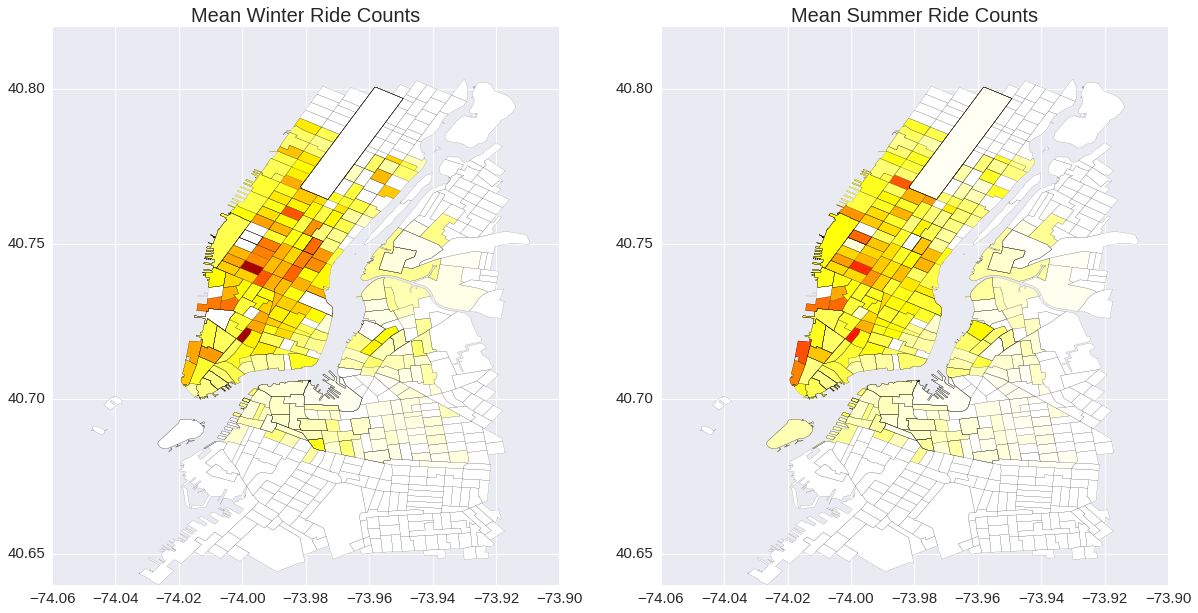

In [56]:
f, ax = plt.subplots(figsize = (20,10))
ax1 = plt.subplot(121)
ax1.get_xaxis().set_visible(True)
ax1.get_yaxis().set_visible(True)
ct_shape_WinterAve_Zoom.plot(column = 'WinterAve', colormap='hot_r',\
                             alpha = 1, linewidth = 0.1, ax = ax1)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize=15, loc='best')
plt.title("Mean Winter Ride Counts", fontsize = 20)

ax2 = plt.subplot(122)
ax2.get_xaxis().set_visible(True)
ax2.get_yaxis().set_visible(True)
ct_shape_SummerAve_Zoom.plot(column = 'SummerAve', colormap = 'hot_r',\
                             alpha = 1, linewidth = 0.1, ax = ax2)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Mean Summer Ride Counts", fontsize = 20)

*** Figure 6: Mean Monthly Citibike Rides per census tract in Winter (left) and Summer (right).*** The relative means are plotted in the heat maps for winter.  In winter, there is a greater difference in riders, as indicated by the darker census tracts.  

### Export Shapefile CTs in the CitiBike Zone

In [57]:
path = 'Output/ct_shape_WinterAve_Zoom.shp'
ct_shape_WinterAve_Zoom.to_file(path)

path = 'Output/ct_shape_SummerAve_Zoom.shp'
ct_shape_SummerAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [58]:
qW_CT = ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [59]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [60]:
qW_CT.cardinalities[10]
#how many friends this index number has

9

#### Matrix of Weights

In [61]:
Wmatrix, ids = qW_CT.full()

In [62]:
Wmatrix
#diagnol of the matrix is 0, bc you are not a friend of yourself

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [63]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [64]:
WinterRide = ct_shape_WinterAve_Zoom.WinterAve
WinterRideLag = ps.lag_spatial(qW_CT, WinterRide)
#give the lag of monthly rider ship, input the weighted

SummerRide = ct_shape_SummerAve_Zoom.SummerAve
SummerRideLag = ps.lag_spatial(qW_CT, SummerRide)
#give the lag of monthly rider ship, input the weighted

#### Create Quantiles for mapping

In [66]:
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k = 10)
print ("Winter Ride Lag", WinterRideLagQ10)
#by having a bin for less than 0, you take out the values that are less than 0

SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k = 10)
print ("Summer Ride Lag", SummerRideLagQ10)
#by having a bin for less than 0, you take out the values that are less than 0

Winter Ride Lag                   Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=   13.786                 2
  13.786 < x[i] <=  156.034                78
 156.034 < x[i] <=  310.559                80
 310.559 < x[i] <=  453.518                79
 453.518 < x[i] <=  796.661                83
 796.661 < x[i] <= 1167.612                76
1167.612 < x[i] <= 1514.213                80
1514.213 < x[i] <= 1841.682                79
1841.682 < x[i] <= 2529.097                80
Summer Ride Lag                   Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=   29.333                 2
  29.333 < x[i] <=  339.931                78
 339.931 < x[i] <=  739.292                80
 739.292 < x[i] <= 1175.623                79
1175.623 < x[i] <= 2047.514                80
2047.514 < x[i] <= 2899.722                7

#### Map the monthly rides lag

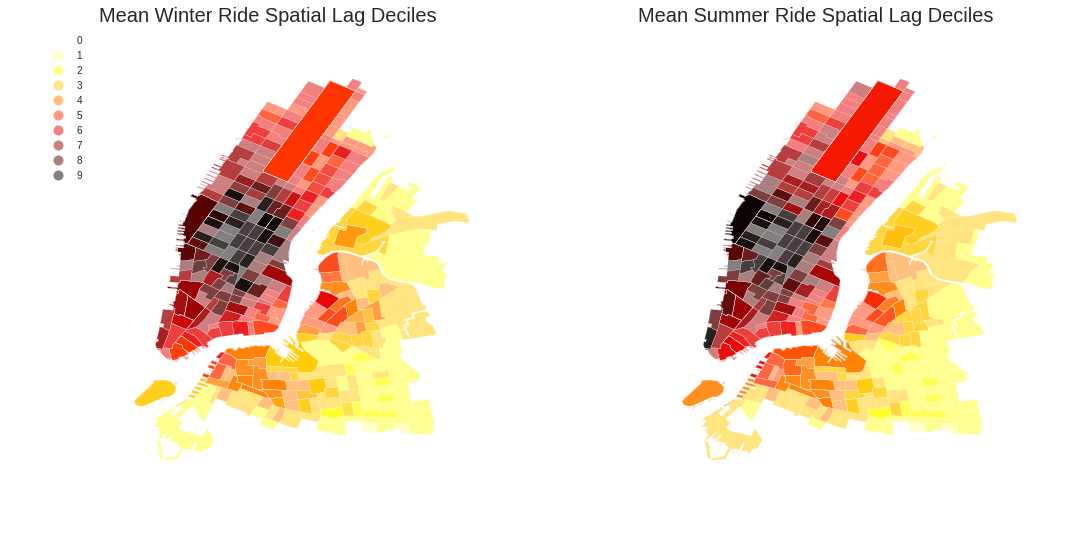

In [68]:
f, ax = plt.subplots(figsize = (18, 9))
ax1 = plt.subplot(121)
ct_shape_WinterAve_Zoom.assign(cl = WinterRideLagQ10.yb).plot(column = 'cl', categorical = True, 
        k=10, cmap = 'hot_r', linewidth = 0.1, ax = ax1, 
        edgecolor = 'white', legend = True)
ax1.set_axis_off()
plt.title("Mean Winter Ride Spatial Lag Deciles", fontsize = 20)

ax2 = plt.subplot(122)
ct_shape_SummerAve_Zoom.assign(cl = SummerRideLagQ10.yb).plot(column = 'cl', categorical = True, 
        k = 10, cmap = 'hot_r', linewidth = 0.1, ax = ax2, 
        edgecolor = 'white', legend = False)
ax2.set_axis_off()
plt.title("Mean Summer Ride Spatial Lag Deciles", fontsize = 20)

*** Figure 7: Mean Winter and Summer Citibike Ride Spatial Lag Deciles ***  For winter, the deciles range from 0 to 2529, and for summer, the deciles range from 0 to 5969.  The spatial lag for each census tract is the average of the mean rides of all the adjacent census tracts.  Although Governor's Island has no direct neighbors, it is counted as the same census tract as the piers in Brooklyn, which are adjacent to census tracts in Brooklyn with valid data.  Midtown Manhattan shows the highest mean number of rides in both winter and summer, with values decreasing uptown, and outwards from the west coast of Brooklyn.

(Governor's island doesn't have any neighbors! But it's counted in the same census tract as the piers)
spatial lag value for each census tract --> its the average of all the surrounding rides
the value in central park is actually the average of all the surrounding neighborhoods

## Global  Spatial Autocorrelation

In [71]:
b,a = np.polyfit(WinterRide, WinterRideLag, 1)
print ("Slope (Winter) = ", b, "Y-intercept: ", a) 
#slope and intercept of a line (linear bc input = 1)

b2,a2 = np.polyfit(SummerRide, SummerRideLag, 1)
print ("Slope (Summer) = ", b2, "Y-intercept: ", a2)

Slope (Winter) =  0.63698720855 Y-intercept:  275.682391236
Slope (Summer) =  0.632666589802 Y-intercept:  688.247199097


### Moran Scatterplot

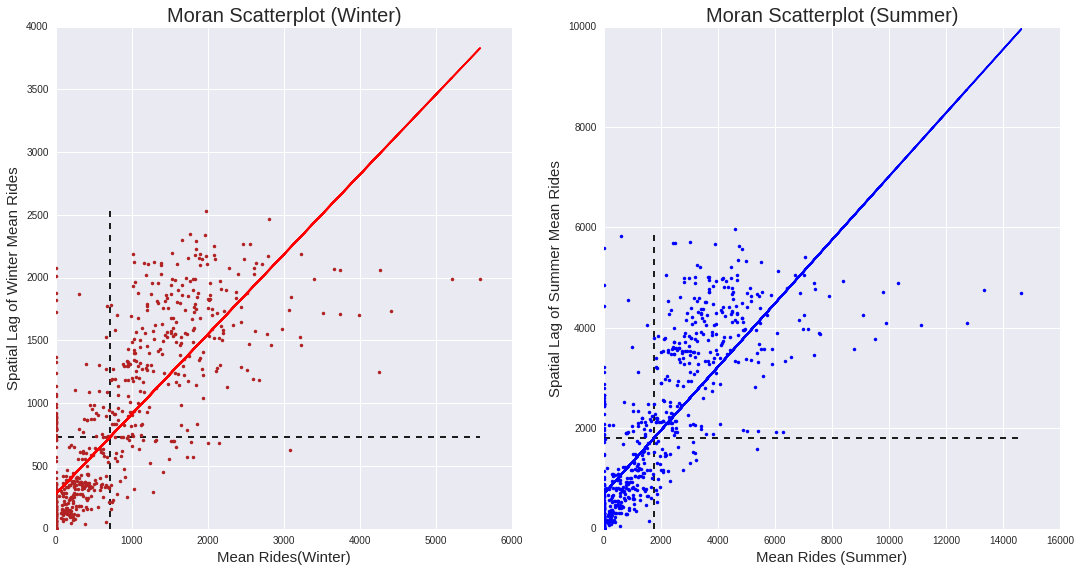

In [72]:
f, ax = plt.subplots(1, figsize = (18, 9))

ax1 = plt.subplot(121)
plt.plot(WinterRide, WinterRideLag, '.', color = 'firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a + b*WinterRide, 'r')
plt.title('Moran Scatterplot (Winter)', fontsize = 20)
plt.ylabel('Spatial Lag of Winter Mean Rides', fontsize = 15)
plt.xlabel('Mean Rides(Winter)', fontsize = 15)

ax2 = plt.subplot(122)
plt.plot(SummerRide, SummerRideLag, '.', color = 'blue')

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a2 + b2*SummerRide, 'b')
plt.title('Moran Scatterplot (Summer)', fontsize = 20)
plt.ylabel('Spatial Lag of Summer Mean Rides', fontsize = 15)
plt.xlabel('Mean Rides (Summer)', fontsize = 15)

*** Figure 8: Spatial Lag versus Mean Citibike Rides for Winter and Summer.*** The model (Moran's I) for both winter and summer shows a strong spatial correlation.  For stations that have a low mean of rides, the neighboring stations also have a low mean of rides (indicated by points plotted in the lower left of the graph.    

### Moran's I

In [73]:
I_WinterRide = ps.Moran(WinterRide, qW_CT)
I_SummerRide = ps.Moran(SummerRide, qW_CT)

In [75]:
print ("Winter", I_WinterRide.I, I_WinterRide.p_sim)
print ("Summer", I_SummerRide.I, I_SummerRide.p_sim)
#same as .65 as before
#0.001 is the p value --> how significant
# only .1% that this would happen randomly

Winter 0.636943296512 0.001
Summer 0.632604946632 0.001


Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [76]:
print ("Winter", I_WinterRide.sim[0:10])
print ("Summer", I_SummerRide.sim[0:10])

Winter [-0.00163374 -0.03244817  0.01843371  0.00030408  0.02546316 -0.00635042
  0.03020148 -0.01631875 -0.00340959 -0.02913915]
Summer [-0.00241957  0.01241561 -0.0085663   0.02926456 -0.00826714 -0.00362845
  0.00359481  0.01292986  0.02427091 -0.00772843]


### KDEplot of all of the simulated points
the vertical line shows the observed value

In [88]:
plt.rcParams['figure.figsize']=(14,6)

(-0.7, 0.7)

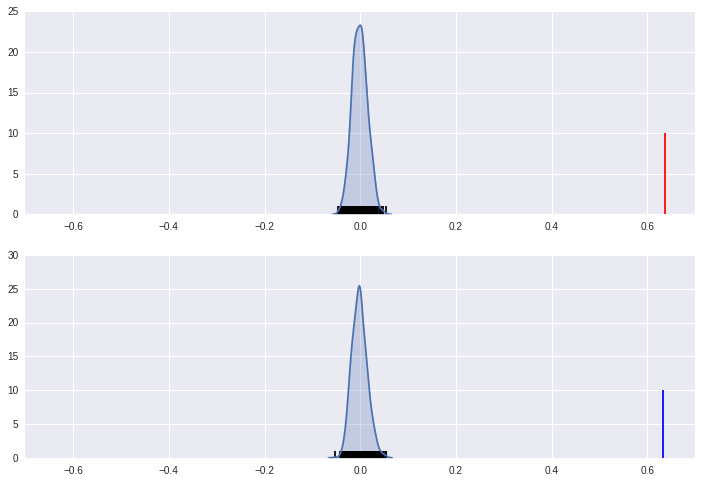

In [77]:
ax1 = plt.subplot(211)
sns.kdeplot(I_WinterRide.sim, shade = True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

ax2 = plt.subplot(212)
sns.kdeplot(I_SummerRide.sim, shade = True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.I, 0, 10, 'b')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

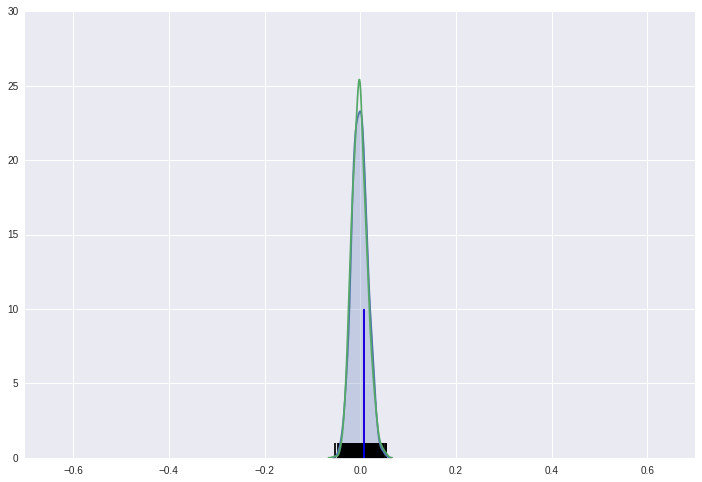

In [78]:
sns.kdeplot(I_WinterRide.sim, shade = True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

sns.kdeplot(I_SummerRide.sim, shade = False)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.EI+.01, 0, 10, 'b')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [79]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT,permutations=999)
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT,permutations=999)
print ("Winter", LMo_WinterRide)
print ("Summer", LMo_SummerRide)

Winter <pysal.esda.moran.Moran_Local object at 0x7f888166e710>
Summer <pysal.esda.moran.Moran_Local object at 0x7f888166e8d0>


In [80]:
print ("Winter", LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5])
print ("Summer", LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5])

Winter [-0.         -0.16685084  0.03921981  0.00954312 -0.13333312] [ 0.001  0.293  0.281  0.279  0.222]
Summer [-0.         -0.08326031  0.01036148  0.02032238 -0.02700394] [ 0.001  0.38   0.365  0.351  0.351]


### LISA (Local Indicators of Spatial Autocorrelation)

In [95]:
Wsigs = WinterRide[LMo_WinterRide.p_sim <= .001]
WW_sigs = WinterRideLag[LMo_WinterRide.p_sim <= .001]
Winsigs = WinterRide[LMo_WinterRide.p_sim > .001]
WW_insigs = WinterRideLag[LMo_WinterRide.p_sim > .001]

Ssigs = SummerRide[LMo_SummerRide.p_sim <= .001]
SW_sigs = SummerRideLag[LMo_SummerRide.p_sim <= .001]
Sinsigs = SummerRide[LMo_SummerRide.p_sim > .001]
SW_insigs = SummerRideLag[LMo_SummerRide.p_sim > .001]

### Plot Signficant LISA

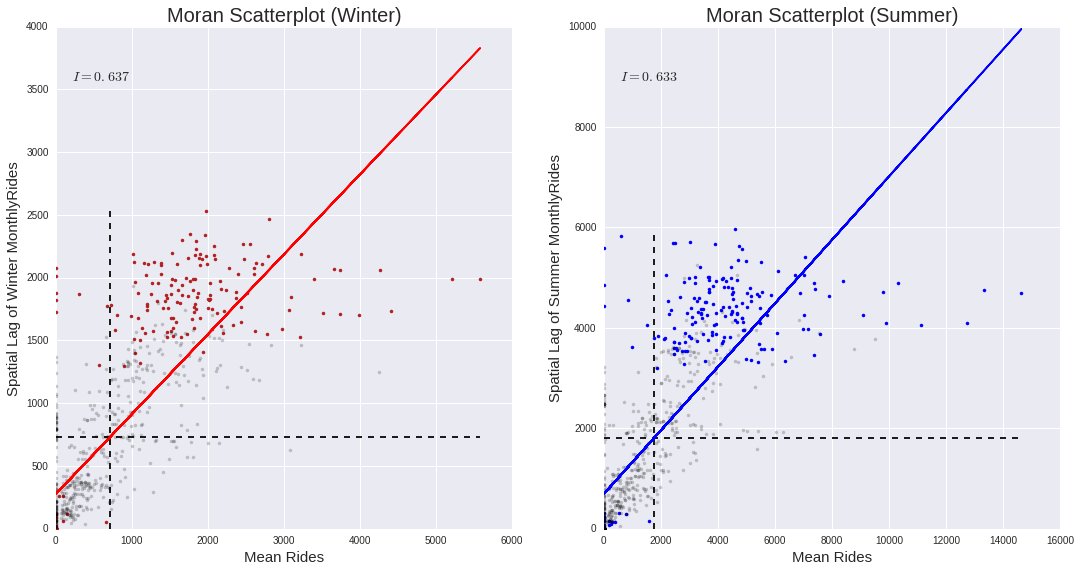

In [100]:
f, ax = plt.subplots(figsize = (18, 9))

ax1 = plt.subplot(121)
plt.plot(Wsigs, WW_sigs, '.', color = 'firebrick')
plt.plot(Winsigs, WW_insigs, '.k', alpha = .2)
#plt.text(s ='$I = %.3f$' % I_WinterRide.I, x = 120000, y = 5000, fontsize = 18)
plt.text(0.1, 0.9,'$I = %.3f$' % I_WinterRide.I,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax1.transAxes)

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a + b*WinterRide, 'r')
plt.title('Moran Scatterplot (Winter)', fontsize = 20)
plt.ylabel('Spatial Lag of Winter MonthlyRides', fontsize = 15)
plt.xlabel('Mean Rides', fontsize = 15)

ax2 = plt.subplot(122)
plt.plot(Ssigs, SW_sigs, '.', color = 'blue')
plt.plot(Sinsigs, SW_insigs, '.k', alpha = .2)
#plt.text(s = '$I = %.3f$' % I_SummerRide.I, x = 120000, y = 5000, fontsize = 18)
plt.text(0.1, 0.9,'$I = %.3f$' % I_SummerRide.I,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax2.transAxes)

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# blue line of best fit using global I as slope
plt.plot(SummerRide, a2 + b2*SummerRide, 'b')
plt.title('Moran Scatterplot (Summer)', fontsize = 20)
plt.ylabel('Spatial Lag of Summer MonthlyRides', fontsize = 15)
plt.xlabel('Mean Rides', fontsize = 15)

*** Figure 9: Spatial Lag versus Mean Citibike Rides in Winter and Summer. *** The gray points are stations that do not show a signficant spatial autocorrelation, and the red the and blue points do show significant autocorrelation.

### Hot and Cold spots 

In [101]:
Wsig = LMo_WinterRide.p_sim < 0.01
#boundary of signficants
w_hotspots = LMo_WinterRide.q==1 * Wsig
w_coldspots = LMo_WinterRide.q==3 * Wsig
print ("Number of Hotspots (Winter):", w_hotspots.sum())
print ("Number of Coldspots (Winter):", w_coldspots.sum())

Ssig = LMo_SummerRide.p_sim < 0.01
#boundary of signficants
s_hotspots = LMo_SummerRide.q==1 * Ssig
s_coldspots = LMo_SummerRide.q==3 * Ssig
print ("Number of Hotspots (Summer):", s_hotspots.sum())
print ("Number of Coldspots (Summer):", s_coldspots.sum())

Number of Hotspots (Winter): 197
Number of Coldspots (Winter): 239
Number of Hotspots (Summer): 216
Number of Coldspots (Summer): 215


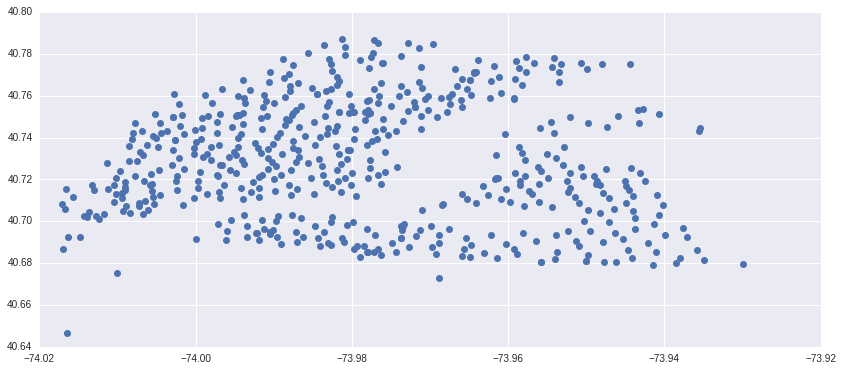

In [112]:
plt.plot(station_id['lon'], station_id['lat'], 'o')

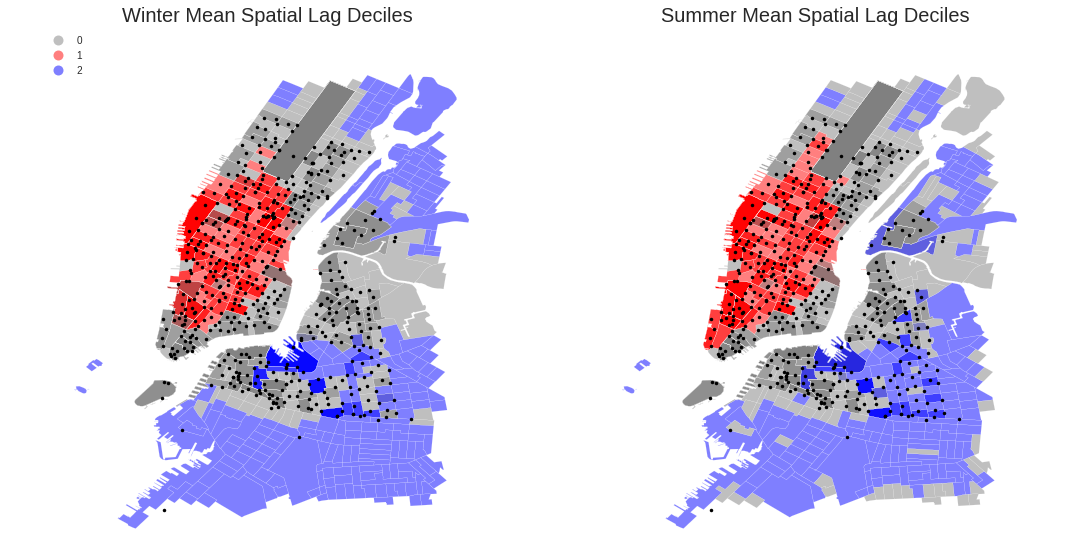

In [118]:
hcmap = colors.ListedColormap(['grey','red','blue'])
w_hotcold = w_hotspots*1 + w_coldspots*2
s_hotcold = s_hotspots*1 + s_coldspots*2
#if its true, it will be 1 * 1
#if its true, it will be 1 * 2
# if false, =0
# so either get 0, 1, 2

f, ax = plt.subplots(figsize=(18, 9))

ax1 = plt.subplot(121)
ct_shape_WinterAve_Zoom.assign(cl = w_hotcold).plot(column = 'cl', categorical = True, 
        k = 10, cmap = hcmap, linewidth = 0.1, ax = ax1, 
        edgecolor = 'white', legend = True)
ax1.set_axis_off()
plt.title("Winter Mean Spatial Lag Deciles", fontsize = 20)
ax1.plot(station_id['lon'], station_id['lat'], '.', color = 'k')

ax2 = plt.subplot(122)
ct_shape_SummerAve_Zoom.assign(cl = s_hotcold).plot(column = 'cl', categorical = True, 
        k = 10, cmap = hcmap, linewidth = 0.1, ax = ax2, 
        edgecolor = 'white', legend = False)
ax2.set_axis_off()
plt.title("Summer Mean Spatial Lag Deciles", fontsize = 20)
ax2.plot(station_id['lon'], station_id['lat'], '.', color = 'k')

*** Figure 10: Hot and Cold Citibike Ridership Spatial Autocorrelation*** The red census tracts are hot spots, meaning that those entire neighborhood clusters have a high amount of citibike rides.  The blue census tracts are cold spots, meaning that those geographic areas and neighborhoods have very littel citibike rides occurring.  For most of these cold spots, there are very few citibike stations, which might explain the low ridership values and the suggested lack of popularity.  The gray census tracts indicate areas where citibike riding is less popular: there is no spatial autocorrelation.   